# Union of Interval Truncation Experiment
Code for the truncated regression experiment, with a union of interval truncation sets.

In [39]:
import sys 
sys.path.append('../..')
from cox.utils import Parameters
import numpy as np
import pandas as pd
import torch as ch
from torch import Tensor
from torch.distributions import Uniform
from torch.distributions.normal import Normal
from torch.utils.data import DataLoader
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from delphi.stats.linear_regression import TruncatedRegression
from delphi.oracle import KIntervalUnion

# Experiment Set Up
Syntheize data, then truncate based off of a union of interval membership oracle.

In [100]:
# number of samples to sample from the uniform distribution
num_samples, dims = 5000, 2

# regression parameters
noise_var = Tensor([1.0])
W = ch.ones(dims, 1)
W0 = ch.ones(1, 1)
X = Uniform(ch.full((dims,), -1.0), ch.full((dims,), 1.0)).sample(ch.Size([num_samples]))

# synthesize data
y = X.mm(W) + W0 + Normal(ch.zeros(1), ch.sqrt(noise_var)).sample(ch.Size([num_samples]))
"""
initialize union of interval truncation set.
IntervalUnion takes in an iterable of tuples with following format [(lower, upper), ... , (lower, upper)]
"""
phi = KIntervalUnion([(Tensor([-float('inf')]), Tensor([-.5])), (Tensor([0.0]), Tensor([0.5])), (Tensor([2.0]), Tensor([float('inf')]))])
# truncate
indices = phi(y).flatten().nonzero(as_tuple=False).flatten()
y_trunc, x_trunc = y[indices], X[indices]

args = Parameters({
    "bias": True,
    "samples": 1000,
    "c": 0,
    "batch_size": 10,
    "lr": 1e-1,
    "var_lr": 1e-1,
    "steps": 1500,
    'val': .2, 
    'n': 100,
    'tol': 1e-2,
})

alpha = Tensor([x_trunc.size(0) / X.size(0)])
print("alpha: ", alpha)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)

alpha:  tensor([0.4702])


LinearRegression()

# Run Procedure

In [103]:
unknown_trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, unknown=True, val=int(args.val*x_trunc.size(0)), bs=args.bs, n=args.n, tol=args.tol, steps=args.steps)
unknown_trunc_reg.fit(x_trunc, y_trunc)

Iteration 1 | Score: 0.9801978468894958
Iteration 2 | Score: 0.3568960726261139
Iteration 3 | Score: 1.3278712034225464
Iteration 4 | Score: 0.07967665791511536
Iteration 5 | Score: 1.9366133213043213
Iteration 6 | Score: 0.5036274790763855
Iteration 7 | Score: 1.0616964101791382
Iteration 8 | Score: 0.283189594745636
Iteration 9 | Score: 0.18989534676074982
Iteration 10 | Score: 0.31034013628959656
Iteration 11 | Score: 0.4695567488670349
Iteration 12 | Score: 0.32485705614089966
Iteration 13 | Score: 0.14979462325572968
Iteration 14 | Score: 0.40434426069259644
Iteration 15 | Score: 0.24475029110908508
Iteration 16 | Score: 0.30135729908943176
Iteration 17 | Score: 0.9892511367797852
Iteration 18 | Score: 0.6799032092094421


LinearUnknownVariance()

# Plot Results

Text(0.5, 0, 'Y')

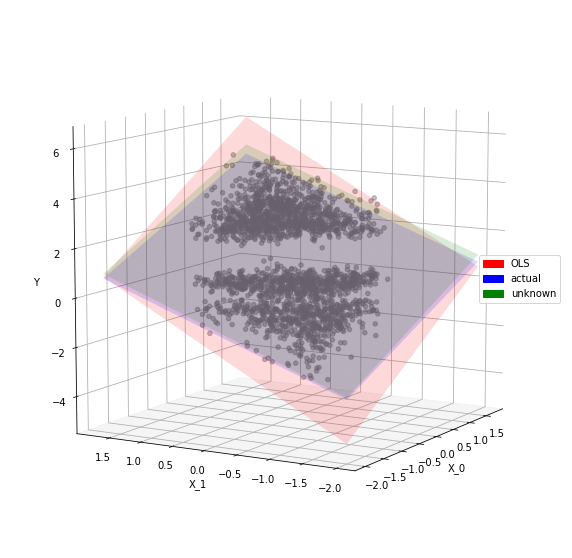

In [104]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="grey", alpha=.5)
with ch.no_grad():
    X = np.arange(-2, 2, 0.25)
    Y = np.arange(-2, 2, 0.25)
    X, Y = np.meshgrid(X, Y)

    # plot predicted regression
    pred = Tensor([unknown_trunc_reg(Tensor(np.concatenate([np.expand_dims(X[i], 1), np.expand_dims(Y[i], 1)], 1)).float()).numpy().flatten() for i in range(X.shape[0])]).numpy()
    ax.plot_surface(X, Y, pred, color="green", alpha=.15)
    
    # plot empirical regression - obtained via OLS
    emp = np.array([trunc_ols.predict(np.concatenate([np.expand_dims(X[i], 1), np.expand_dims(Y[i], 1)], 1)).flatten() for i in range(X.shape[0])])
    ax.plot_surface(X, Y, emp, color="red", alpha=.15)
    
    # plot actual regression - based off of synthetic data
    act = ch.cat([(Tensor(np.concatenate([np.expand_dims(X[i], 1), np.expand_dims(Y[i], 1)], 1)).float().mm(W) + W0) for i in range(X.shape[0])], 1).numpy()
    ax.plot_surface(X, Y, act, color="blue", alpha=.15)
    


red_patch = mpatches.Patch(color='red', label='OLS')

green_patch = mpatches.Patch(color='green', label='unknown')
blue_patch = mpatches.Patch(color='blue', label="actual")
plt.legend(handles=[red_patch, blue_patch, green_patch], loc="center right")

ax.view_init(10, -150)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.set_xlabel('X_0')
ax.set_ylabel('X_1')
ax.set_zlabel('Y')